In [1]:
import ARXT
from ARXT import hit_rate
import Data_gen
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
import matplotlib.pyplot as plt
import logging
import bayesian_changepoint_detection.bayesian_models as bayes_models
from bayesian_changepoint_detection.hazard_functions import constant_hazard


Use scipy logsumexp().


In [2]:
def get_data():

    # tickers = ["^GSPC", "^IXIC", "^DJI","JPYUSD=X", "^VIX"] # , "GBPUSD=X", "EURUSD=X",
    # data = Data_gen.collect_data(tickers)
    data = pd.read_csv("../Data/fin_data.csv")
    # data.to_csv("Data/fin_data.csv")
    data.index = data["Date"]
    data = data.drop(["Date"], axis=1)
    data.columns = range(data.shape[1])

    return(data)

def train_run_tree(data, p, max_depth, min_size, splt):
    p, max_depth, min_size =  int(round(p)), int(round(max_depth)), int(round(min_size))
    d_val_cumsum, valid_prediction_cumsum, tree_list = ARXT.ARXT_time_series_pred(data=data, p=p, preprocessing_method='normalization', max_depth=max_depth, min_size=min_size, splt=splt)
    hit_rate_sample = hit_rate(d_val_cumsum, valid_prediction_cumsum)

    rmse_sample = (sqrt(mean_squared_error(d_val_cumsum, valid_prediction_cumsum)))

    return d_val_cumsum, valid_prediction_cumsum, tree_list, hit_rate_sample, rmse_sample
DATA = get_data()

def objective_function(p, max_depth, min_size, start, fin, splt):
    # Set up and train the ART model using the hyperparameters
    p, max_depth, min_size =  round(p), round(max_depth), round(min_size)
    d_val_cumsum, valid_prediction_cumsum, _, hit_rate_sample, rmse_sample = train_run_tree(DATA[start:fin], p, max_depth, min_size, splt=splt)

    performance = hit_rate_sample * 2 - rmse_sample * 0.5
    return performance
def optimizer(pbounds, start, fin, splt):
    optimizer = BayesianOptimization(f= lambda p, max_depth, min_size: objective_function(p, max_depth, min_size,start, fin, splt), pbounds=pbounds, random_state=1)
    acq_function = UtilityFunction(kind="ei", kappa=5, kappa_decay=0.8)
    optimizer.maximize(init_points=2, n_iter=5, acquisition_function = acq_function)
    opt_params  = optimizer.max['params']
    plot_constrained_opt(pbounds, f, optimizer)

    return opt_params

In [3]:
n = 1e5
X = DATA.iloc[:,1]
Y = DATA.iloc[:,0]
x, y = X, Y
y = []
# x = X.ravel()
# y = Y.ravel()
# X = np.vstack([x, y]).T[:, [1, 0]]
# z = objective_function(p, max_depth, min_size, start, fin, splt)

IndexError: list index out of range

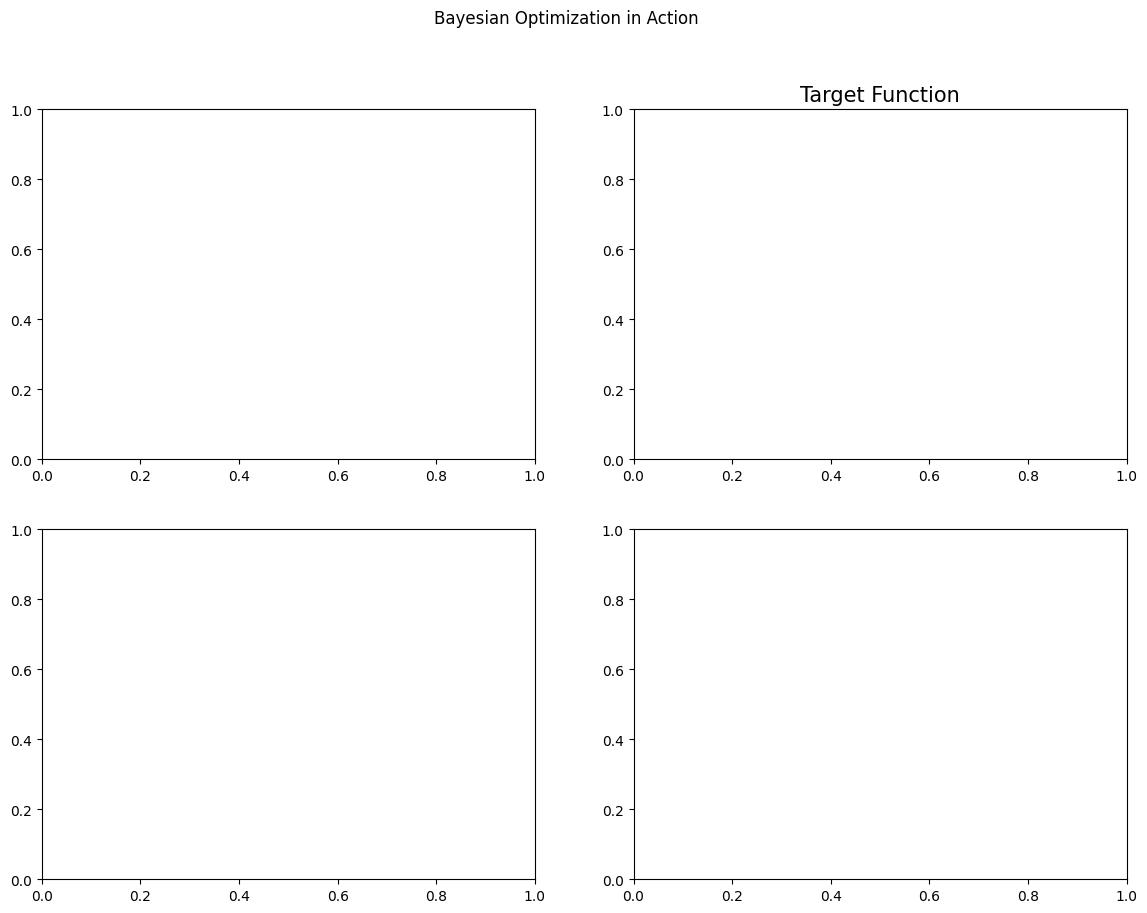

In [44]:
from matplotlib import cm
bo = optimizer
f= lambda p, max_depth, min_size: objective_function(p, max_depth, min_size,0, 1000, "exog")
def posterior(bo, X):
    bo._gp.fit(X, Y)
    mu, sigma2 = bo._gp.predict(X, eval_MSE=True)
    return mu, np.sqrt(sigma2), bo.util.utility(X, bo._gp, Y.max())

def plot_2d(name=None):
    # ut = bo.util.utility(X, bo._gp, Y.max())

    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    gridsize=150

    fig.suptitle('Bayesian Optimization in Action', fontdict={'size':30})

    # GP regression output
    # ax[0][0].set_title('Gausian Process Predicted Mean', fontdict={'size':15})
    # im00 = ax[0][0].hexbin(x, y, C=mu, gridsize=gridsize, cmap=cm.jet, bins=None)
    # ax[0][0].axis([x.min(), x.max(), y.min(), y.max()])
    # ax[0][0].plot(bo.X[:, 1], bo.X[:, 0], 'D', markersize=4, color='k', label='Observations')

    ax[0][1].set_title('Target Function', fontdict={'size':15})
    im10 = ax[0][1].hexbin(x, y, C=z, gridsize=gridsize, cmap=cm.jet, bins=None)
    ax[0][1].axis([x.min(), x.max(), y.min(), y.max()])
    ax[0][1].plot(bo.X[:, 1], bo.X[:, 0], 'D', markersize=4, color='k')
    # ax[0][0].legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

    # ax[1][0].set_title('Gausian Process Variance', fontdict={'size':15})
    # im01 = ax[1][0].hexbin(x, y, C=s, gridsize=gridsize, cmap=cm.jet, bins=None)
    # ax[1][0].axis([x.min(), x.max(), y.min(), y.max()])

    # ax[1][1].set_title('Acquisition Function', fontdict={'size':15})
    # im11 = ax[1][1].hexbin(x, y, C=ut, gridsize=gridsize, cmap=cm.jet, bins=None)

    np.where(ut.reshape((300, 300)) == ut.max())[0]
    np.where(ut.reshape((300, 300)) == ut.max())[1]

    ax[1][1].plot([np.where(ut.reshape((300, 300)) == ut.max())[1]/50., 
                   np.where(ut.reshape((300, 300)) == ut.max())[1]/50.], 
                  [0, 6], 
                  'k-', lw=2, color='k')

    ax[1][1].plot([0, 6],
                  [np.where(ut.reshape((300, 300)) == ut.max())[0]/50., 
                   np.where(ut.reshape((300, 300)) == ut.max())[0]/50.], 
                  'k-', lw=2, color='k')

    ax[1][1].axis([x.min(), x.max(), y.min(), y.max()])

    for im, axis in zip([im00, im01, im10, im11], ax.flatten()):
        cb = fig.colorbar(im, ax=axis)
        cb.set_label('Value')
        
    if name is None:
        name = '_'
    
    # pp = PdfPages('bo_eg_' + name + '.pdf')
    # pp.savefig(fig)
    fig.savefig('bo_eg_' + name + '.png')
plot_2d()

In [5]:
splt="exog"
train_len = 1000
# Define hyperparameter bounds
pbounds = {
    "p": (5, 10),
    "max_depth":(10, 15),
    "min_size":(10, 20)
}
# opt_params = optimizer(pbounds, 0 , train_len, splt)
opt_params = {"max_depth": 21.46, "min_size": 21.52, "p": 5.903}

p, max_depth, min_size = round(opt_params['p']), round(opt_params['max_depth']), round(opt_params['min_size'])
next_pbounds = {"p": (p*0.7, p*1.3), "max_depth" : (max_depth*0.7, max_depth*1.3), "min_size" : (min_size*0.7, min_size*1.3)}


In [11]:
optimizer = BayesianOptimization(f= lambda p, max_depth, min_size: objective_function(p, max_depth, min_size,0 , train_len, splt), pbounds=pbounds, random_state=1)
acq_function = UtilityFunction(kind="ei", kappa=5, kappa_decay=0.8)
optimizer.maximize(init_points=2, n_iter=5, acquisition_function = acq_function)
opt_params  = optimizer.max['params']


AttributeError: 'dict' object has no attribute 'gp'

In [50]:
optimizer.max

{'target': -7.5490495104324875,
 'params': {'max_depth': 15.0, 'min_size': 20.0, 'p': 5.0}}

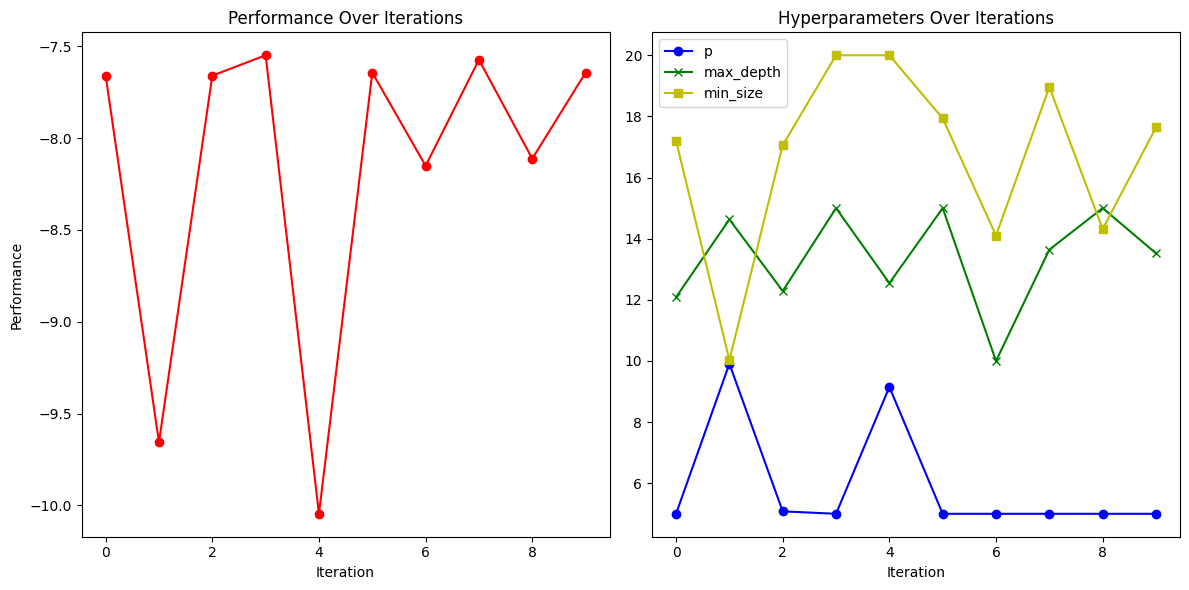

In [47]:
from bayes_opt import BayesianOptimization, UtilityFunction
import matplotlib.pyplot as plt

# Assuming pbounds is defined somewhere as:
# pbounds = {'p': (min_p, max_p), 'max_depth': (min_max_depth, max_max_depth), 'min_size': (min_min_size, max_min_size)}

# Placeholder for the start, fin, and splt variables
start, fin, splt = 0, 100, 0.8 # You will need to replace these with your actual values.

# Initialize the Bayesian Optimization
optimizer = BayesianOptimization(
    f=lambda p, max_depth, min_size: objective_function(p, max_depth, min_size, start, fin, splt),
    pbounds=pbounds,
    random_state=1
)

# Acquisition function
acq_function = UtilityFunction(kind="ei", kappa=5, kappa_decay=0.8)

# Number of iterations
n_iter = 10

# Lists to store results
performance_history = []
p_history = []
max_depth_history = []
min_size_history = []

for _ in range(n_iter):
    # Select the next point to sample
    next_point = optimizer.suggest(acq_function)
    # Evaluate the objective function at the suggested point
    target = objective_function(**next_point, start=0, fin=train_len,splt=splt)
    # Update the optimizer
    optimizer.register(params=next_point, target=target)

    # Store the results
    performance_history.append(target)
    p_history.append(next_point['p'])
    max_depth_history.append(next_point['max_depth'])
    min_size_history.append(next_point['min_size'])

# Plotting the performance over iterations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(performance_history, 'r-', marker='o')
plt.title("Performance Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Performance")

# Plotting the hyperparameters over iterations
plt.subplot(1, 2, 2)
plt.plot(p_history, 'b-', marker='o', label='p')
plt.plot(max_depth_history, 'g-', marker='x', label='max_depth')
plt.plot(min_size_history, 'y-', marker='s', label='min_size')
plt.title("Hyperparameters Over Iterations")
plt.xlabel("Iteration")
plt.legend()

plt.tight_layout()
plt.show()


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9


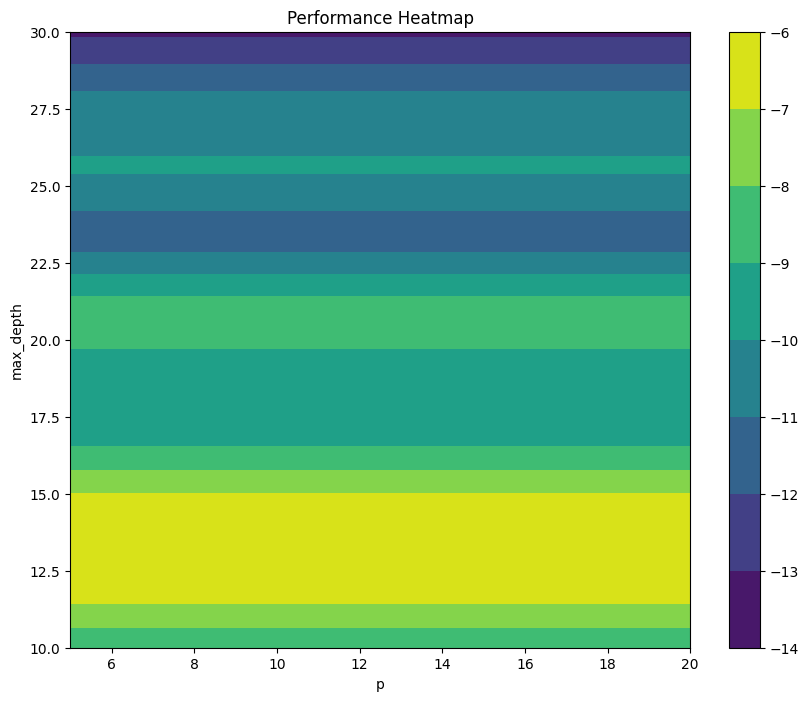

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Define the parameter grid
p_range = np.linspace(5, 20, 10)
max_depth_range = np.linspace(10, 30, 10)

# Generate a grid of points
p_grid, max_depth_grid = np.meshgrid(p_range, max_depth_range)
performance_grid = np.zeros(p_grid.shape)

# Evaluate the objective function at each point
for i in range(p_grid.shape[0]):
    for j in range(p_grid.shape[1]):
        print(i,j)
        performance_grid[i, j] = objective_function(p_range[i], max_depth_range[j], 20, 0, 200, splt)

# Now, performance_grid contains the performance for each combination of p and max_depth

# Plot the heatmap
plt.figure(figsize=(10, 8))
cp = plt.contourf(p_grid, max_depth_grid, performance_grid, cmap=cm.viridis)
plt.colorbar(cp)
plt.title('Performance Heatmap')
plt.xlabel('p')
plt.ylabel('max_depth')
plt.show()


In [12]:
performance_grid


array([[ -8.80290684,  -8.80290684,  -8.80290684,  -8.80290684,
         -8.80290684,  -8.80290684,  -8.80290684,  -8.80290684,
         -8.80290684,  -8.80290684],
       [ -6.01134464,  -6.01134464,  -6.01134464,  -6.01134464,
         -6.01134464,  -6.01134464,  -6.01134464,  -6.01134464,
         -6.01134464,  -6.01134464],
       [ -6.26134163,  -6.26134163,  -6.26134163,  -6.26134163,
         -6.26134163,  -6.26134163,  -6.26134163,  -6.26134163,
         -6.26134163,  -6.26134163],
       [ -9.15565261,  -9.15565261,  -9.15565261,  -9.15565261,
         -9.15565261,  -9.15565261,  -9.15565261,  -9.15565261,
         -9.15565261,  -9.15565261],
       [ -9.23264182,  -9.23264182,  -9.23264182,  -9.23264182,
         -9.23264182,  -9.23264182,  -9.23264182,  -9.23264182,
         -9.23264182,  -9.23264182],
       [ -8.58587569,  -8.58587569,  -8.58587569,  -8.58587569,
         -8.58587569,  -8.58587569,  -8.58587569,  -8.58587569,
         -8.58587569,  -8.58587569],
       [-1

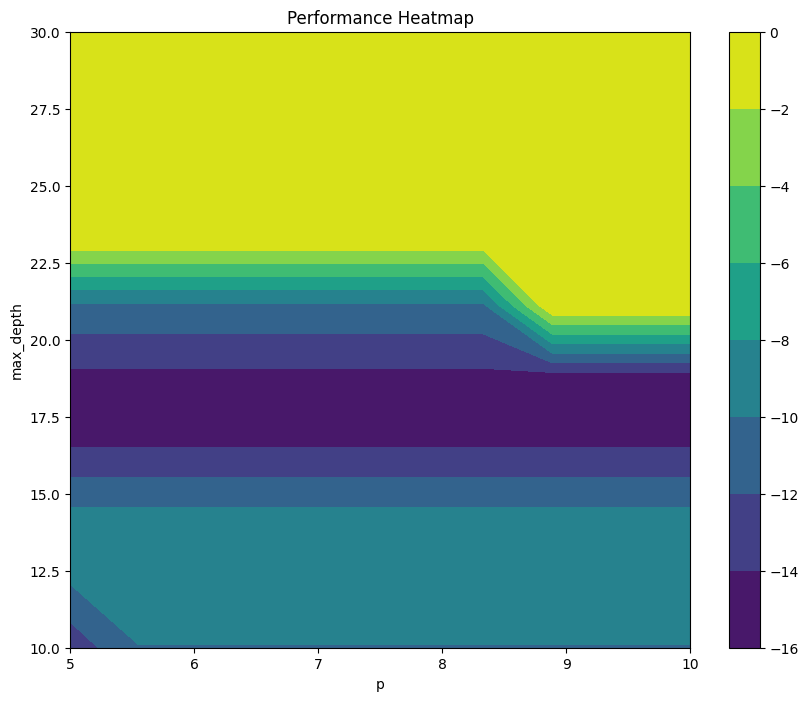

In [7]:
plt.figure(figsize=(10, 8))
cp = plt.contourf(p_grid, max_depth_grid, performance_grid, cmap=cm.viridis)
plt.colorbar(cp)
plt.title('Performance Heatmap')
plt.xlabel('p')
plt.ylabel('max_depth')
plt.show()